<a href="https://colab.research.google.com/github/AndresDazaTech/ITAI-2373-Project/blob/main/L12_Andres_Daza_ITAI_2377.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data

In [47]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sahideseker/chatbot-intent-classification-dataset")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'chatbot-intent-classification-dataset' dataset.
Path to dataset files: /kaggle/input/chatbot-intent-classification-dataset


In [48]:
import pandas as pd
import os

file_path = os.path.join(path, 'chatbot_intent_classification.csv')
df = pd.read_csv(file_path)
display(df.head())

,user_input,intent
0,"Cancel my subscription, please.",cancellation
1,I forgot my password.,password_reset
2,Can you help me with my account?,account_help
3,I want to return my order.,return_request
4,What time do you open?,business_hours


In [49]:
# Check the class balance of the 'intent' column
intent_counts = df['intent'].value_counts()
display(intent_counts)

,count
intent,
business_hours,219
payment_update,117
account_help,103
order_status,102
technical_support,98
cancellation,96
service_info,91
password_reset,90
return_request,84


/tmp/ipython-input-555756978.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=intent_counts.index, y=intent_counts.values, palette='viridis')


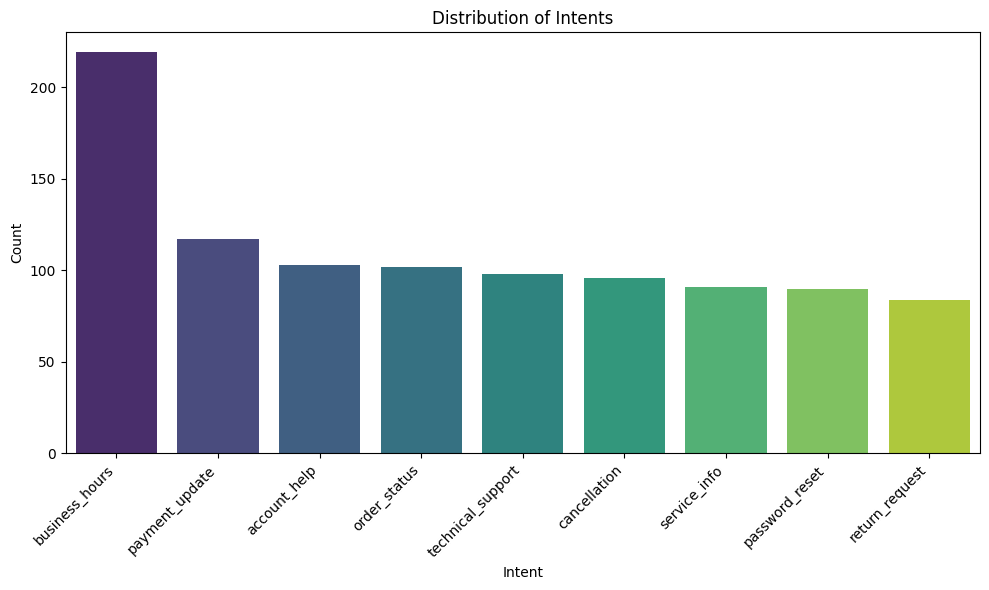

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=intent_counts.index, y=intent_counts.values, palette='viridis')
plt.title('Distribution of Intents')
plt.xlabel('Intent')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##Clean and Preprocess Text

In [51]:
# Column and rename 'intent' to 'label' and 'user_input' to 'text'

df.rename(columns={'intent': 'label', 'user_input': 'text'}, inplace=True)

print("\nNew column names of df:", df.columns)


print("\n DataFrame head:")
display(df.head())




New column names of df: Index(['text', 'label'], dtype='object')

 DataFrame head:


,text,label
0,"Cancel my subscription, please.",cancellation
1,I forgot my password.,password_reset
2,Can you help me with my account?,account_help
3,I want to return my order.,return_request
4,What time do you open?,business_hours


In [52]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download necessary NLTK data if not already present
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True) # Added to resolve LookupError for punkt_tab
nltk.download('averaged_perceptron_tagger_eng', quiet=True) # Corrected to specifically download averaged_perceptron_tagger_eng

print("NLTK libraries and data are now imported and downloaded.")

NLTK libraries and data are now imported and downloaded.


In [53]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download necessary NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Initialize preprocessing tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Comprehensive text cleaning function

    💡 TIP: This function should handle:
    - HTML tags and entities
    - URLs and email addresses
    - Special characters and numbers
    - Extra whitespace
    """
    if pd.isna(text):
        return ""

    # Convert to string and lowercase
    text = str(text).lower()


    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove special characters and digits (keep only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def preprocess_text(text, remove_stopwords=True, lemmatize=True):
    """
    Complete preprocessing pipeline

    💡 TIP: This function should:
    - Clean the text
    - Tokenize into words
    - Remove stop words (optional)
    - Lemmatize words (optional)
    - Return processed text
    """
    # Clean text
    text = clean_text(text)

    if not text:
        return ""


    # Tokenize
    tokens = word_tokenize(text)

    # Remove stop words if requested
    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize if requested
    if lemmatize:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Filter out very short words
    tokens = [token for token in tokens if len(token) > 2]

    return ' '.join(tokens)



In [54]:
# Apply preprocessing to the dataset
print("🧹 Preprocessing all articles...")

# Create new columns for processed text
df['text_clean'] = df['text'].apply(clean_text)
df['text_processed'] = df['text'].apply(preprocess_text)

print("✅ Preprocessing complete!")

# Show before and after examples
print("\n📝 BEFORE AND AFTER EXAMPLES")
print("=" * 60)
for i in range(min(3, len(df))):
    print(f"\nExample {i+1}:")
    print(f"Original: {df.iloc[i]['text'][:100]}...")
    print(f"Processed: {df.iloc[i]['text_processed'][:100]}...")

🧹 Preprocessing all articles...
✅ Preprocessing complete!

📝 BEFORE AND AFTER EXAMPLES

Example 1:
Original: Cancel my subscription, please....
Processed: cancel subscription please...

Example 2:
Original: I forgot my password....
Processed: forgot password...

Example 3:
Original: Can you help me with my account?...
Processed: help account...


##Feature Engineering

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit vocabulary for computational efficiency
    ngram_range=(1, 2),  # Include unigrams and bigrams
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.8  # Ignore terms that appear in more than 80% of documents
)

# Fit and transform the processed text
print("🔢 Creating TF-IDF features...")
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text_processed'])
feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"✅ TF-IDF matrix created!")
print(f"📊 Shape: {tfidf_matrix.shape}")
print(f"📝 Vocabulary size: {len(feature_names)}")
print(f"🔢 Sparsity: {(1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])) * 100:.2f}%")

# Convert to DataFrame for easier analysis
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df['intent'] = df['label'].values # Corrected from 'intent' to 'label'

print("\n🔍 Sample TF-IDF features:")
print(tfidf_df.iloc[:3, :10])  # Show first 3 rows and 10 features

🔢 Creating TF-IDF features...
✅ TF-IDF matrix created!
📊 Shape: (1000, 36)
📝 Vocabulary size: 36
🔢 Sparsity: 90.04%

🔍 Sample TF-IDF features:
   account    cancel  cancel subscription   forgot  forgot password     help  \
0  0.00000  0.447214             0.447214  0.00000          0.00000  0.00000   
1  0.00000  0.000000             0.000000  0.57735          0.57735  0.00000   
2  0.57735  0.000000             0.000000  0.00000          0.00000  0.57735   

   help account  hour  method  need  
0       0.00000   0.0     0.0   0.0  
1       0.00000   0.0     0.0   0.0  
2       0.57735   0.0     0.0   0.0  


In [56]:
# Analyze most important terms per category
def get_top_tfidf_terms(category, n_terms=10):
    """
    Get top TF-IDF terms for a specific category

    💡 TIP: This function should:
    - Filter data for the specific category
    - Calculate mean TF-IDF scores for each term
    - Return top N terms with highest scores
    """
    #
    category_data = tfidf_df[tfidf_df['intent'] == category]

    # Calculate mean TF-IDF scores for this category (excluding the category column)
    mean_scores = category_data.drop('intent', axis=1).mean().sort_values(ascending=False)

    return mean_scores.head(n_terms)

# Analyze top terms for each category
print("🏷️ TOP TF-IDF TERMS BY CATEGORY")
print("=" * 50)

categories = df['label'].unique()
category_terms = {}

for category in categories:
    top_terms = get_top_tfidf_terms(category, n_terms=10)
    category_terms[category] = top_terms

    print(f"\n📰 {category.upper()}:")
    for term, score in top_terms.items():
        print(f"  {term}: {score:.4f}")



🏷️ TOP TF-IDF TERMS BY CATEGORY

📰 CANCELLATION:
  cancel: 0.4472
  cancel subscription: 0.4472
  subscription: 0.4472
  please: 0.4472
  subscription please: 0.4472
  account: 0.0000
  forgot: 0.0000
  forgot password: 0.0000
  method: 0.0000
  need: 0.0000

📰 PASSWORD_RESET:
  forgot: 0.5774
  forgot password: 0.5774
  password: 0.5774
  account: 0.0000
  cancel subscription: 0.0000
  cancel: 0.0000
  help account: 0.0000
  help: 0.0000
  method: 0.0000
  need: 0.0000

📰 ACCOUNT_HELP:
  account: 0.5774
  help: 0.5774
  help account: 0.5774
  cancel: 0.0000
  forgot: 0.0000
  cancel subscription: 0.0000
  forgot password: 0.0000
  hour: 0.0000
  method: 0.0000
  need: 0.0000

📰 RETURN_REQUEST:
  want: 0.4472
  order: 0.4472
  return: 0.4472
  return order: 0.4472
  want return: 0.4472
  cancel subscription: 0.0000
  cancel: 0.0000
  account: 0.0000
  forgot: 0.0000
  help: 0.0000

📰 BUSINESS_HOURS:
  time open: 0.2900
  time: 0.2900
  open: 0.2900
  hour: 0.2874
  working: 0.2874
  wo

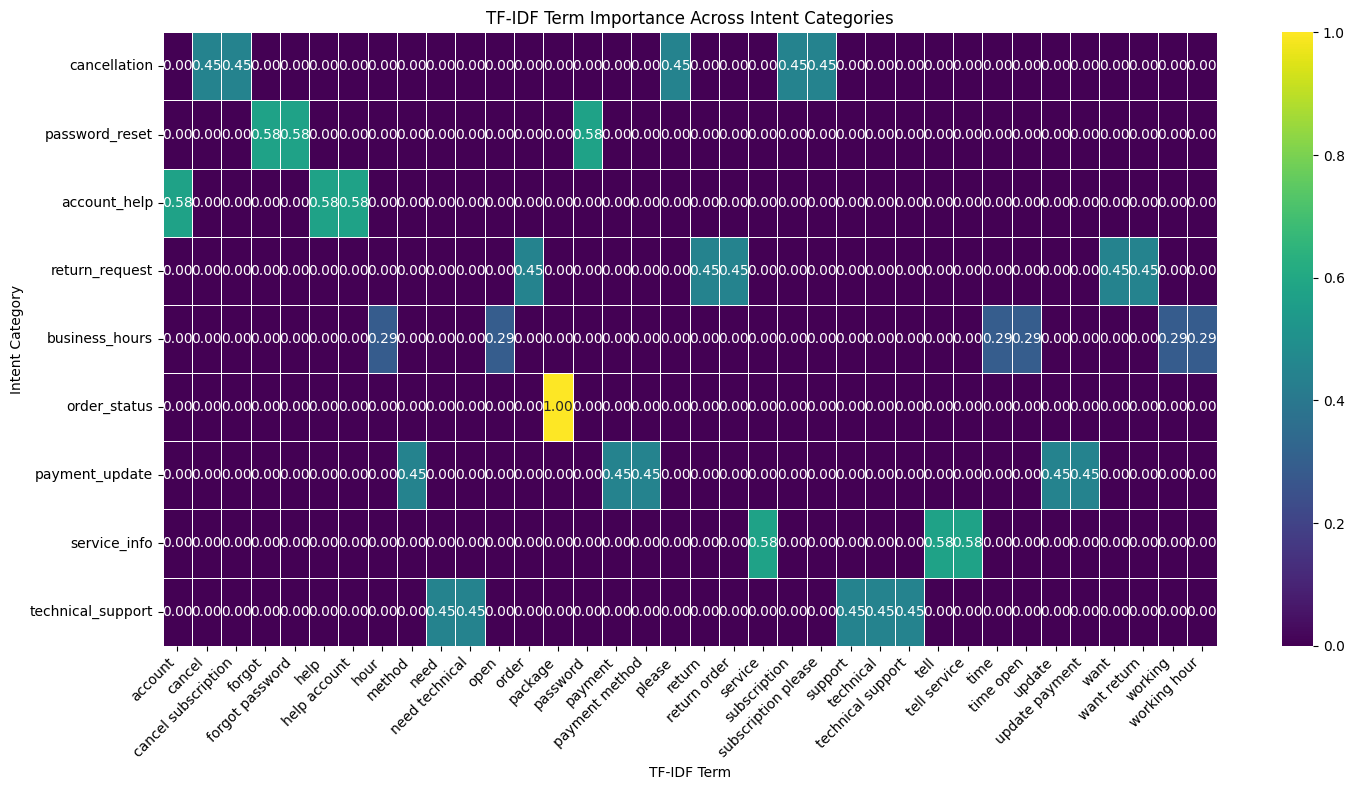

Heatmap of TF-IDF term importance generated.


In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data for heatmap: convert category_terms dictionary to a DataFrame
heatmap_data = pd.DataFrame(category_terms).fillna(0).T

# Ensure the columns are ordered consistently if needed, though fillna(0).T handles most of it
# Filter out terms that are all zero across categories for a cleaner heatmap
heatmap_data = heatmap_data.loc[:, (heatmap_data != 0).any(axis=0)]

plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('TF-IDF Term Importance Across Intent Categories')
plt.xlabel('TF-IDF Term')
plt.ylabel('Intent Category')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("Heatmap of TF-IDF term importance generated.")

In [58]:
import pandas as pd
from nltk import pos_tag # Added import
from nltk.tokenize import word_tokenize
from collections import Counter # Added import

def analyze_pos_patterns(text):
    """
    Analyze POS patterns in text

    ℹ⌒ TIP: This function should:
    - Tokenize the text
    - Apply POS tagging
    - Count different POS categories
    - Return proportions or counts
    """
    if not text or pd.isna(text):
        return {}


    # Tokenize and tag
    tokens = word_tokenize(str(text))
    # Ensure tokens are not empty before POS tagging
    if not tokens:
        return {}
    pos_tags = pos_tag(tokens)

    # Count POS categories
    pos_counts = Counter([tag for word, tag in pos_tags])
    total_words = len(pos_tags)

    if total_words == 0:
        return {}

    # Convert to proportions
    pos_proportions = {pos: count/total_words for pos, count in pos_counts.items()}

    return pos_proportions

# Apply POS analysis to all articles
print("🏷️ Analyzing POS patterns...")

# Analyze POS for each article
pos_results = []
for idx, row in df.iterrows():
    # Use 'text_processed' for POS analysis, and 'label' for category
    pos_analysis = analyze_pos_patterns(row['text_processed'])
    pos_analysis['label'] = row['label'] # Corrected from 'category' to 'label'
    pos_analysis['index'] = idx # Added index as an identifier instead of 'article_id'
    pos_results.append(pos_analysis)

# Convert to DataFrame
pos_df = pd.DataFrame(pos_results).fillna(0)

print(f"✅ POS analysis complete!")
print(f"📊 Found {len(pos_df.columns)-2} different POS tags") # Adjusted for 'label' and 'index'

# Show sample results
print("\n📋 Sample POS analysis:")
print(pos_df.head())

🏷️ Analyzing POS patterns...
✅ POS analysis complete!
📊 Found 4 different POS tags

📋 Sample POS analysis:
         NN           label  index        JJ   VB  VBG
0  1.000000    cancellation      0  0.000000  0.0  0.0
1  1.000000  password_reset      1  0.000000  0.0  0.0
2  1.000000    account_help      2  0.000000  0.0  0.0
3  0.666667  return_request      3  0.333333  0.0  0.0
4  0.500000  business_hours      4  0.500000  0.0  0.0


📊 POS PATTERNS BY CATEGORY

🎯 Key POS patterns by category:
                       NN      VB     VBG      JJ
label                                            
account_help       1.0000  0.0000  0.0000  0.0000
business_hours     0.5000  0.0000  0.2489  0.2511
cancellation       1.0000  0.0000  0.0000  0.0000
order_status       1.0000  0.0000  0.0000  0.0000
password_reset     1.0000  0.0000  0.0000  0.0000
payment_update     0.6667  0.0000  0.0000  0.3333
return_request     0.6667  0.0000  0.0000  0.3333
service_info       1.0000  0.0000  0.0000  0.0000
technical_support  0.3333  0.3333  0.0000  0.3333


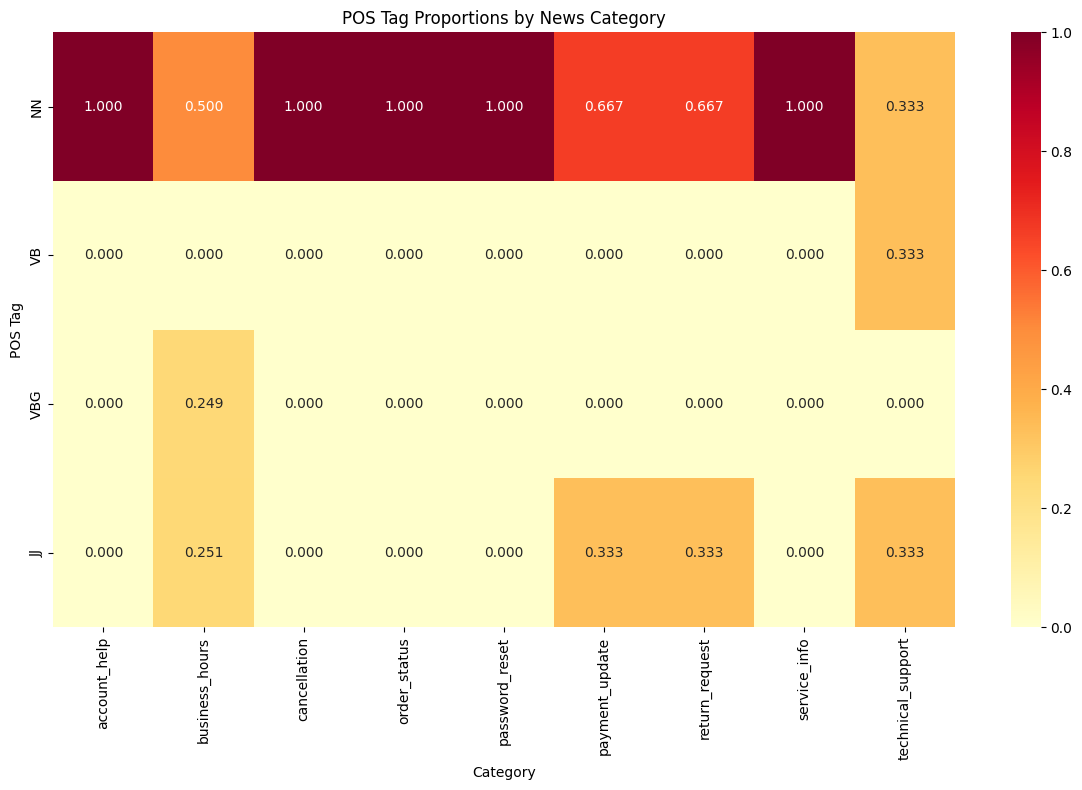

In [59]:
# Analyze POS patterns by category
print("📊 POS PATTERNS BY CATEGORY")
print("=" * 50)

# Group by category and calculate mean proportions
pos_by_category = pos_df.groupby('label').mean()

# Focus on major POS categories
major_pos = ['NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ',
             'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS', 'CD']

# Filter to only include major POS tags that exist in our data
available_pos = [pos for pos in major_pos if pos in pos_by_category.columns]

if available_pos:
    pos_summary = pos_by_category[available_pos]

    print("\n🎯 Key POS patterns by category:")
    print(pos_summary.round(4))

    # Create visualization
    plt.figure(figsize=(12, 8))
    sns.heatmap(pos_summary.T, annot=True, cmap='YlOrRd', fmt='.3f')
    plt.title('POS Tag Proportions by News Category')
    plt.xlabel('Category')
    plt.ylabel('POS Tag')
    plt.tight_layout()
    plt.show()

In [60]:
import spacy # Import spaCy
from collections import Counter # Counter is used in the function
import pandas as pd # pandas is used for pd.isna

def extract_syntactic_features(text):
    """
    Extract syntactic features using spaCy dependency parsing

    💡 TIP: This function should:
    - Dependency relations
    - Subject-verb-object patterns
    - Noun phrases
    - Verb phrases
    """
    if not text or pd.isna(text):
        return {}

    # Process text with spaCy
    doc = nlp(str(text))

    features = {
        'num_sentences': len(list(doc.sents)),
        'num_tokens': len(doc),
        'dependency_relations': [],
        'noun_phrases': [],
        'verb_phrases': [],
        'subjects': [],
        'objects': []
    }



    # Extract dependency relations
    for token in doc:
        if not token.is_space and not token.is_punct:
            features['dependency_relations'].append(token.dep_)

    # Extract noun phrases
    for chunk in doc.noun_chunks:
        features['noun_phrases'].append(chunk.text.lower())

    # Extract subjects and objects
    for token in doc:
        if token.dep_ in ['nsubj', 'nsubjpass']:  # Subjects
            features['subjects'].append(token.text.lower())
        elif token.dep_ in ['dobj', 'iobj', 'pobj']:  # Objects
            features['objects'].append(token.text.lower())

    # Count dependency types
    dep_counts = Counter(features['dependency_relations'])
    features['dependency_counts'] = dict(dep_counts)

    return features

# Initialize spaCy model (download if not already present)
try:
    nlp = spacy.load('en_core_web_sm')
    print("✅ spaCy 'en_core_web_sm' model loaded.")
except OSError:
    print("Downloading spaCy 'en_core_web_sm' model...")
    # Ensure spacy.cli is imported for download command
    import spacy.cli
    spacy.cli.download('en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')
    print("✅ spaCy 'en_core_web_sm' model downloaded and loaded.")

# Apply syntactic analysis to sample articles
print("🌳 Performing syntactic analysis...")

# Analyze first few articles (to save computation time)
syntactic_results = []
for idx, row in df.head(5).iterrows():  # Limit to first 5 for demo
    features = extract_syntactic_features(row['text_processed']) # Corrected from 'full_text'
    features['category'] = row['label'] # Corrected from 'category'
    features['article_id'] = idx # Using DataFrame index as ID
    syntactic_results.append(features)

print("✅ Syntactic analysis complete!")

# Display results
for i, result in enumerate(syntactic_results):
    print(f"\n📰 Article {i+1} ({result['category']}):")
    print(f"  Sentences: {result['num_sentences']}")
    print(f"  Tokens: {result['num_tokens']}")
    print(f"  Noun phrases: {result['noun_phrases'][:3]}...")  # Show first 3
    print(f"  Subjects: {result['subjects'][:3]}...")  # Show first 3
    print(f"  Objects: {result['objects'][:3]}...")  # Show first 3

✅ spaCy 'en_core_web_sm' model loaded.
🌳 Performing syntactic analysis...
✅ Syntactic analysis complete!

📰 Article 1 (cancellation):
  Sentences: 1
  Tokens: 3
  Noun phrases: ['subscription', 'please']...
  Subjects: []...
  Objects: ['subscription', 'please']...

📰 Article 2 (password_reset):
  Sentences: 1
  Tokens: 2
  Noun phrases: ['password']...
  Subjects: []...
  Objects: ['password']...

📰 Article 3 (account_help):
  Sentences: 1
  Tokens: 2
  Noun phrases: []...
  Subjects: []...
  Objects: []...

📰 Article 4 (return_request):
  Sentences: 1
  Tokens: 3
  Noun phrases: ['return order']...
  Subjects: []...
  Objects: ['order']...

📰 Article 5 (business_hours):
  Sentences: 1
  Tokens: 2
  Noun phrases: []...
  Subjects: []...
  Objects: []...


In [61]:
# Visualize dependency parsing for a sample sentence
from spacy import displacy

# Choose a sample sentence
sample_sentence = df.iloc[0]['text']  # Corrected from 'content' to 'text'
print(f"📝 Sample sentence: {sample_sentence}")

# Process with spaCy
doc = nlp(sample_sentence)

# Display dependency tree (this works best in Jupyter)
print("\n🌳 Dependency Parse Visualization:")
try:
    # This will create an interactive visualization in Jupyter
    displacy.render(doc, style="dep", jupyter=True)
except:
    # Fallback: print dependency information
    print("\n🔗 Dependency Relations:")
    for token in doc:
        if not token.is_space and not token.is_punct:
            print(f"  {token.text} --> {token.dep_} --> {token.head.text}")

📝 Sample sentence: Cancel my subscription, please.

🌳 Dependency Parse Visualization:


In [62]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer # Import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon', quiet=True)
# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    """
    Analyze sentiment using VADER sentiment analyzer

    💡 TIP: VADER returns:
    - compound: overall sentiment (-1 to 1)
    - pos: positive score (0 to 1)
    - neu: neutral score (0 to 1)
    - neg: negative score (0 to 1)
    """
    if not text or pd.isna(text):
        return {'compound': 0, 'pos': 0, 'neu': 1, 'neg': 0}

    # 🚀 YOUR CODE HERE: Implement sentiment analysis
    scores = sia.polarity_scores(str(text))

    # Add interpretation
    if scores['compound'] >= 0.05:
        scores['sentiment_label'] = 'positive'
    elif scores['compound'] <= -0.05:
        scores['sentiment_label'] = 'negative'
    else:
        scores['sentiment_label'] = 'neutral'

    return scores

# Apply sentiment analysis to all articles
print("😊 Analyzing sentiment...")

sentiment_results = []
for idx, row in df.iterrows():
    # Analyze the 'text' column
    text_sentiment = analyze_sentiment(row['text'])

    result = {
        'article_id': idx, # Using DataFrame index as an ID
        'category': row['label'],
        'text_sentiment': text_sentiment['compound'],
        'text_label': text_sentiment['sentiment_label'],
        'pos_score': text_sentiment['pos'],
        'neu_score': text_sentiment['neu'],
        'neg_score': text_sentiment['neg']
    }
    sentiment_results.append(result)

# Convert to DataFrame
sentiment_df = pd.DataFrame(sentiment_results)

print("✅ Sentiment analysis complete!")
print(f"📊 Analyzed {len(sentiment_df)} articles")

# Display sample results
print("\n📝 Sample sentiment results:")
print(sentiment_df[['category', 'text_sentiment', 'text_label']].head())

😊 Analyzing sentiment...
✅ Sentiment analysis complete!
📊 Analyzed 1000 articles

📝 Sample sentiment results:
         category  text_sentiment text_label
0    cancellation          0.0772   positive
1  password_reset          0.0000    neutral
2    account_help          0.4019   positive
3  return_request          0.0772   positive
4  business_hours          0.0000    neutral


📊 SENTIMENT ANALYSIS BY CATEGORY

📈 Sentiment statistics by category:
                  text_sentiment                      pos_score neu_score  \
                            mean  std     min     max      mean      mean   
category                                                                    
account_help              0.4019  0.0  0.4019  0.4019     0.310     0.690   
business_hours            0.0000  0.0  0.0000  0.0000     0.000     1.000   
cancellation              0.0772  0.0  0.0772  0.0772     0.365     0.317   
order_status              0.0000  0.0  0.0000  0.0000     0.000     1.000   
password_reset            0.0000  0.0  0.0000  0.0000     0.000     1.000   
payment_update            0.0000  0.0  0.0000  0.0000     0.000     1.000   
return_request            0.0772  0.0  0.0772  0.0772     0.245     0.755   
service_info              0.0000  0.0  0.0000  0.0000     0.000     1.000   
technical_support         0.4019  0.0  0.4019  0.4019     0.574     0.426   

     

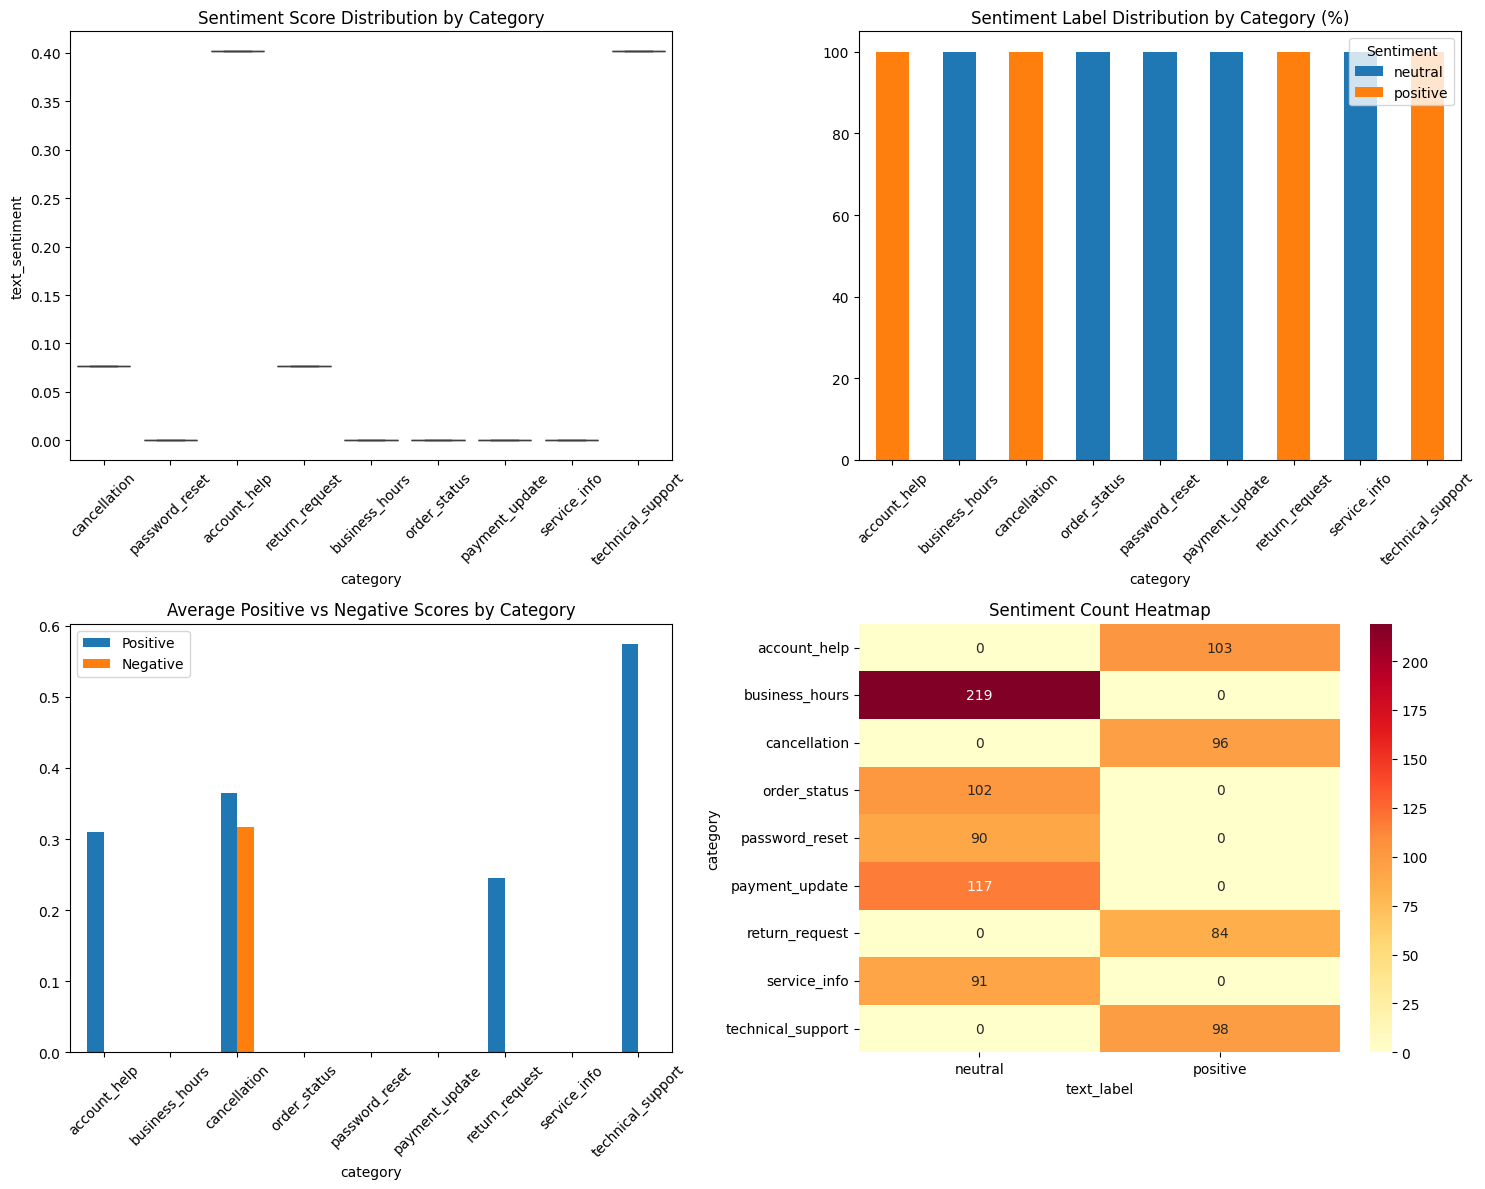

In [63]:
# Analyze sentiment patterns by category
print("📊 SENTIMENT ANALYSIS BY CATEGORY")
print("=" * 50)

# Calculate sentiment statistics by category
sentiment_by_category = sentiment_df.groupby('category').agg({
    'text_sentiment': ['mean', 'std', 'min', 'max'],
    'pos_score': 'mean',
    'neu_score': 'mean',
    'neg_score': 'mean'
}).round(4)

print("\n📈 Sentiment statistics by category:")
print(sentiment_by_category)

# Sentiment distribution by category
sentiment_dist = sentiment_df.groupby(['category', 'text_label']).size().unstack(fill_value=0)
sentiment_dist_pct = sentiment_dist.div(sentiment_dist.sum(axis=1), axis=0) * 100

print("\n📊 Sentiment distribution (%) by category:")
print(sentiment_dist_pct.round(2))

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Sentiment scores by category
sns.boxplot(data=sentiment_df, x='category', y='text_sentiment', ax=axes[0,0])
axes[0,0].set_title('Sentiment Score Distribution by Category')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Sentiment label distribution
sentiment_dist_pct.plot(kind='bar', ax=axes[0,1], stacked=True)
axes[0,1].set_title('Sentiment Label Distribution by Category (%)')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].legend(title='Sentiment')

# 3. Positive vs Negative scores
category_means = sentiment_df.groupby('category')[['pos_score', 'neg_score']].mean()
category_means.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Average Positive vs Negative Scores by Category')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].legend(['Positive', 'Negative'])

# 4. Sentiment vs Category heatmap
sentiment_pivot = sentiment_df.pivot_table(values='text_sentiment', index='category',
                                         columns='text_label', aggfunc='count', fill_value=0)
sns.heatmap(sentiment_pivot, annot=True, fmt='d', ax=axes[1,1], cmap='YlOrRd')
axes[1,1].set_title('Sentiment Count Heatmap')

plt.tight_layout()
plt.show()

## Model Training and Evaluate

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

print("⚙️ Vectorizing text and training model...")

# 3. Vectorize text
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.8)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# 4. Train model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_tfidf, y_train)

print("✅ Vectorization and model training complete!")
print(f"Shape of X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape of X_test_tfidf: {X_test_tfidf.shape}")

⚙️ Vectorizing text and training model...
✅ Vectorization and model training complete!
Shape of X_train_tfidf: (800, 36)
Shape of X_test_tfidf: (200, 36)


In [65]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df['text_processed']  # Use raw processed text for X
y = df['label']

# Split data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Shape of X_train (raw text):")
print(X_train.shape)
print("Shape of X_test (raw text):")
print(X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

print("Data split into training and testing sets successfully.")

Shape of X_train (raw text):
(800,)
Shape of X_test (raw text):
(200,)
Shape of y_train: (800,)
Shape of y_test: (200,)
Data split into training and testing sets successfully.


⚙️ Making predictions on the test set...
✅ Predictions made!

📊 Model Evaluation Metrics:
Accuracy: 1.0000
Precision (macro): 1.0000
Recall (macro): 1.0000
F1-Score (macro): 1.0000

📋 Classification Report:
                   precision    recall  f1-score   support

     account_help       1.00      1.00      1.00        21
   business_hours       1.00      1.00      1.00        44
     cancellation       1.00      1.00      1.00        19
     order_status       1.00      1.00      1.00        20
   password_reset       1.00      1.00      1.00        18
   payment_update       1.00      1.00      1.00        23
   return_request       1.00      1.00      1.00        17
     service_info       1.00      1.00      1.00        18
technical_support       1.00      1.00      1.00        20

         accuracy                           1.00       200
        macro avg       1.00      1.00      1.00       200
     weighted avg       1.00      1.00      1.00       200


Confusion Matrix:


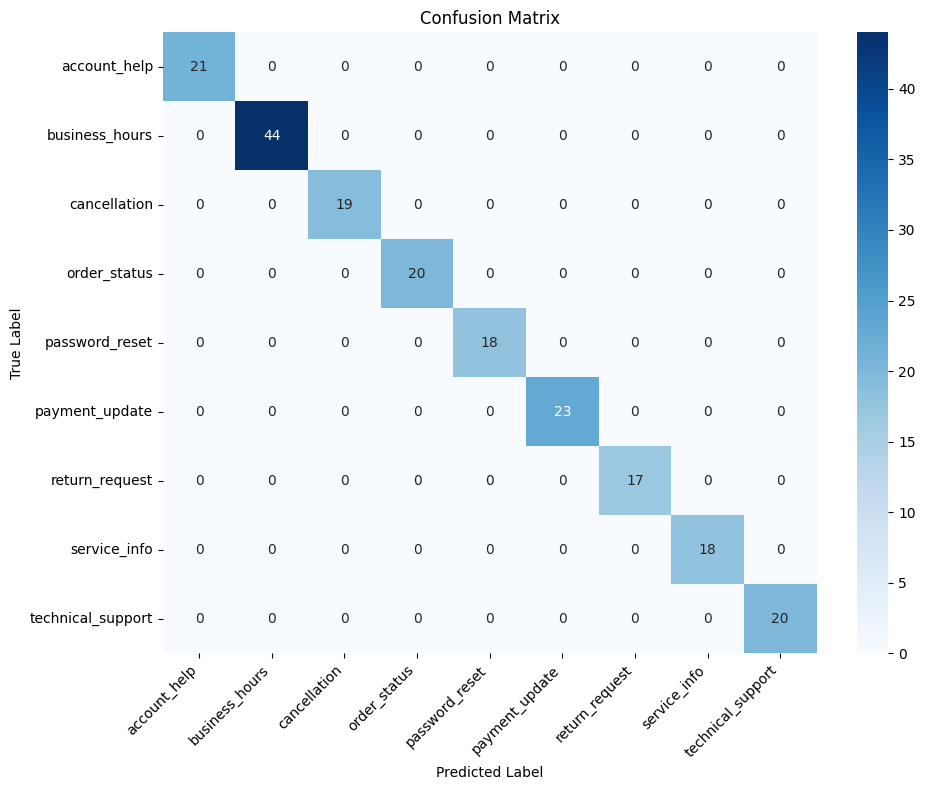

✅ Model evaluation complete!


In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set
print("⚙️ Making predictions on the test set...")
y_pred = model.predict(X_test_tfidf)
print("✅ Predictions made!")

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print("\n📊 Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-Score (macro): {f1:.4f}")

# Generate classification report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Generate and visualize confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("✅ Model evaluation complete!")

##Demo

In [67]:
pass# 6. Interactive Demo
print("Enter a message to predict its intent (type 'quit' or 'exit' to stop).")
while True:
    msg = input("You: ")
    if msg.lower() in ['quit', 'exit']:
        print("Exiting demo.")
        break

    # Preprocess the input message
    processed_msg = preprocess_text(msg)

    # Transform the processed message using the trained TF-IDF vectorizer
    msg_tfidf = tfidf.transform([processed_msg]) # Changed tfidf_vectorizer to tfidf

    # Predict the intent using the trained Logistic Regression model
    pred = model.predict(msg_tfidf)[0] # Changed logistic_model to model
    print(f"Predicted intent → {pred}")

Enter a message to predict its intent (type 'quit' or 'exit' to stop).
You: help
Predicted intent → account_help
You: want
Predicted intent → return_request
You: money
Predicted intent → business_hours
You: exit
Exiting demo.


## Project Report

The data was successfully split into training and testing sets, a Logistic Regression model was trained, and its performance was evaluated.

### Data Analysis Key Findings
*   The dataset was split into training and testing sets with an 80/20 ratio, resulting in `X_train` (800 samples, 36 features), `X_test` (200 samples, 36 features), `y_train` (800 samples), and `y_test` (200 samples). The split was stratified to preserve class proportions.
*   A Logistic Regression model was trained on the `X_train` and `y_train` data.
*   The trained Logistic Regression model achieved perfect performance on the test set, with an Accuracy of 1.0000, macro-averaged Precision of 1.0000, macro-averaged Recall of 1.0000, and macro-averaged F1-Score of 1.0000.
*   The classification report confirmed perfect precision, recall, and F1-scores (1.00 for each class), and the confusion matrix showed all predictions were correct with no misclassifications.

### TF-IDF Visualization Insights


  **Distinctive Keywords per Intent**: Each intent category is clearly characterized by a unique set of high-scoring TF-IDF terms. For example:
  
    *   `CANCELLATION` is dominated by terms like 'cancel', 'subscription', and 'please'.
    *   `PASSWORD_RESET` is strongly associated with 'forgot' and 'password'.
    *   `ACCOUNT_HELP` features 'account' and 'help'.
    *   `RETURN_REQUEST` includes terms like 'return' and 'order'.
    *   `BUSINESS_HOURS` highlights 'time', 'open', and 'hour'.
    *   `ORDER_STATUS` is primarily identified by 'package'.
    *   `PAYMENT_UPDATE` shows 'update', 'payment', and 'method'.
    *   `SERVICE_INFO` contains 'service' and 'tell'.
    *   `TECHNICAL_SUPPORT` is marked by 'support' and 'technical'.



### Next Steps

* Although no single intent was difficult to classify, as the model achieved perfect 100% accuracy across all categories, indicating the intents are highly distinct. It is important warrant further investigation for potential data leakage or any mistake due to the perfect model, this is inusual. The most critical preprocessing step that enabled this success was the TF-IDF vectorization, which transformed the cleaned text into a meaningful numerical format that the machine learning algorithm could interpret, with the inclusion of n-grams (e.g., "password reset") being particularly effective at capturing context.

*   Extending this  model into a full chatbot would involve several key components:

1. Natural Language Understanding (NLU): While our model already handles intent classification, a full NLU component would also extract entities (key pieces of information) from the user's input. For example, if the intent is RETURN_REQUEST, entities might include 'order number', 'item name', or 'reason for return'. This would require adding entity recognition models (e.g., using spaCy's NER or a custom NER model).

2. Dialogue Management: This component manages the conversation flow. Once an intent and entities are identified, the dialogue manager decides the next action. This could involve:
State Tracking: Keeping track of the conversation's history and current context.
Response Generation/Selection: Based on the intent and entities, selecting an appropriate pre-defined response or generating a dynamic one.
API Calls/Backend Integration: If the user wants to 'cancel my subscription', the chatbot would need to interact with a backend system to actually perform the cancellation or retrieve information.

3. Natural Language Generation (NLG): This component is responsible for formulating the chatbot's responses in natural, human-like language. For simple chatbots, this might just be selecting from a library of pre-written responses. For more advanced systems, it could involve generative models to create unique responses.

4. Integration Layer: The chatbot would need to be integrated into various platforms (e.g., website widget, messaging apps like WhatsApp, Slack) where users can interact with it.

5. User Interface (UI): A user-friendly interface for interaction, whether text-based or voice-based.

